# Analyzing Boston's Rideshare Data

In [27]:
# General imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import copy

# Data pipeline imports
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load Data Set

In [14]:
df = pd.read_excel('rideshare.xls')
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


## EDA

In [15]:
# Get shape of the data set
df.shape

(11999, 57)

In [16]:
# Get number of null values
df.isnull().sum()

id                               0
timestamp                        0
hour                             0
day                              0
month                            0
datetime                         0
timezone                         0
source                           0
destination                      0
cab_type                         0
product_id                       0
name                             0
price                          931
distance                         0
surge_multiplier                 0
latitude                         0
longitude                        0
temperature                      0
apparentTemperature              0
short_summary                    0
long_summary                     0
precipIntensity                  0
precipProbability                0
humidity                         0
windSpeed                        0
windGust                         0
windGustTime                     0
visibility                       0
temperatureHigh     

In [17]:
# Number of unique values in each data set
df.nunique()

id                             11999
timestamp                      10878
hour                              24
day                               17
month                              2
datetime                        9253
timezone                           1
source                            12
destination                       12
cab_type                           2
product_id                        13
name                              13
price                            101
distance                         360
surge_multiplier                   6
latitude                          11
longitude                         12
temperature                      308
apparentTemperature              319
short_summary                      9
long_summary                      11
precipIntensity                   63
precipProbability                 29
humidity                          51
windSpeed                        291
windGust                         286
windGustTime                      25
v

# Preprocessing Pipeline

- Drop unneeded columns
- Encode categorical columns
- Impute price column:
    - <strong>Remove column</strong> = Losing potential data values but also means that we aren't guessing the price

In [19]:
# Define drop columns
drop = ['id', 'hour', 'day', 'month', 'timezone', 'timestamp', 'latitude', 'longitude', 'product_id', 
        'uvIndexTime', 'short_summary', 'visibility.1', 'icon']

# Add all columns with Time measurements -> we only need one time measurement
for cols in df.columns:
    if "Time" in cols:
        drop.append(cols)

In [20]:
# Drop columns
df = df.drop(drop,axis=1)
df = df.dropna()

In [21]:
# Create two seperate dataframes (Uber & Lyft) for further analysis later on
df_uber = df[df['cab_type'] == "Uber"]
df_lyft = df[df['cab_type'] == "Lyft"]

In [94]:
df.head()

,datetime,source,destination,cab_type,name,price,distance,surge_multiplier,temperature,apparentTemperature,...,cloudCover,uvIndex,visibility.1,ozone,moonPhase,precipIntensityMax,temperatureMin,temperatureMax,apparentTemperatureMin,apparentTemperatureMax
0,2018-12-16 09:30:07,Haymarket Square,North Station,Lyft,Shared,5.0,0.44,1.0,42.34,37.12,...,0.72,0,10.000,303.8,0.30,0.1276,39.89,43.68,33.73,38.07
1,2018-11-27 02:00:23,Haymarket Square,North Station,Lyft,Lux,11.0,0.44,1.0,43.58,37.35,...,1.00,0,4.786,291.1,0.64,0.1300,40.49,47.30,36.20,43.92
2,2018-11-28 01:00:22,Haymarket Square,North Station,Lyft,Lyft,7.0,0.44,1.0,38.33,32.93,...,0.03,0,10.000,315.7,0.68,0.1064,35.36,47.55,31.04,44.12
3,2018-11-30 04:53:02,Haymarket Square,North Station,Lyft,Lux Black XL,26.0,0.44,1.0,34.38,29.63,...,0.00,0,10.000,291.1,0.75,0.0000,34.67,45.03,30.30,38.53
4,2018-11-29 03:49:20,Haymarket Square,North Station,Lyft,Lyft XL,9.0,0.44,1.0,37.44,30.88,...,0.44,0,10.000,347.7,0.72,0.0001,33.10,42.18,29.11,35.75


# Data Visualization

### Distribution of Prices Across Rideshare Companies

/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


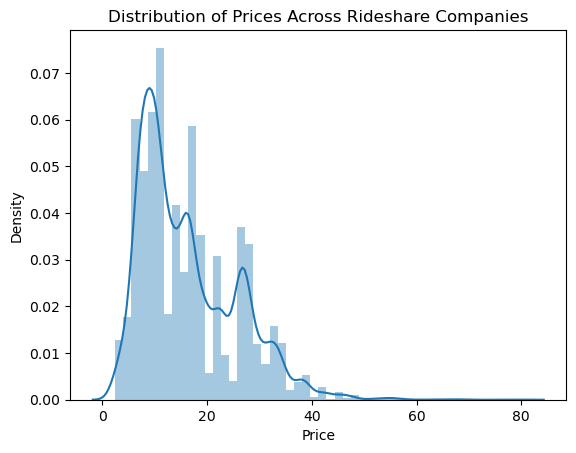

In [60]:
sns.distplot(df['price'], kde=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Prices Across Uber and Lyft');

/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/srihariraman/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


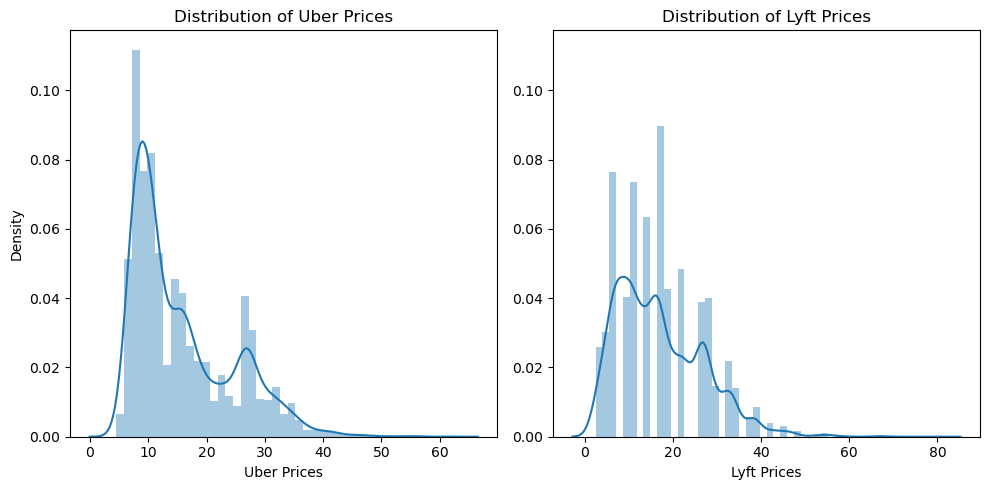

In [67]:
# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution for Uber
sns.distplot(df_uber['price'], ax=axes[0])

# Plot the distribution for Lyft
sns.distplot(df_lyft['price'], ax=axes[1])

# Set the same y-value limit for both plots
max_y = max(max(axes[0].get_ylim()), max(axes[1].get_ylim()))
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

# Set titles and labels
axes[0].set_title('Distribution of Uber Prices')
axes[0].set_xlabel('Uber Prices')
axes[0].set_ylabel('Density')

axes[1].set_title('Distribution of Lyft Prices')
axes[1].set_xlabel('Lyft Prices')
axes[1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [70]:
df.columns

Index(['datetime', 'source', 'destination', 'cab_type', 'name', 'price',
       'distance', 'surge_multiplier', 'temperature', 'apparentTemperature',
       'long_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'temperatureHigh',
       'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow',
       'icon', 'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'moonPhase', 'precipIntensityMax',
       'temperatureMin', 'temperatureMax', 'apparentTemperatureMin',
       'apparentTemperatureMax'],
      dtype='object')

### Distribution of Prices Against Major Weather Patterns

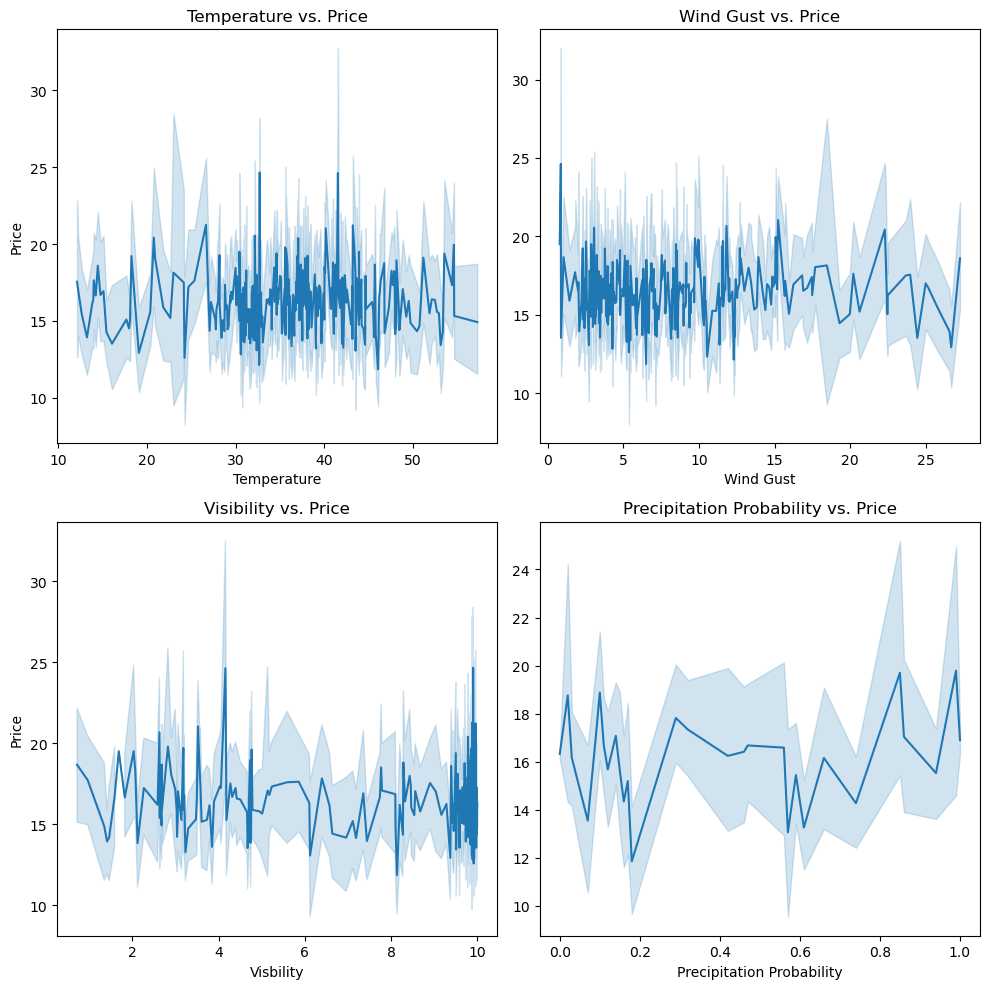

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Set up lineplots for each variable
sns.lineplot(data=df, x='apparentTemperature', y='price', ax=axes[0, 0])  # Top left subplot
sns.lineplot(data=df, x='windGust', y='price', ax=axes[0, 1])  # Top right subplot
sns.lineplot(data=df, x='visibility', y='price', ax=axes[1, 0])  # Bottom left subplot
sns.lineplot(data=df, x='precipProbability', y='price', ax=axes[1, 1])  # Bottom right subplot

# Set titles and labels
axes[0, 0].set_title('Temperature vs. Price')
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Price')

axes[0, 1].set_title('Wind Gust vs. Price')
axes[0, 1].set_xlabel('Wind Gust')
axes[0, 1].set_ylabel('')

axes[1, 0].set_title('Visibility vs. Price')
axes[1, 0].set_xlabel('Visbility')
axes[1, 0].set_ylabel('Price')

axes[1, 1].set_title('Precipitation Probability vs. Price')
axes[1, 1].set_xlabel('Precipitation Probability')
axes[1, 1].set_ylabel('')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

### Distribution of Prices Against Distance

Text(13.819444444444445, 0.5, 'Price')

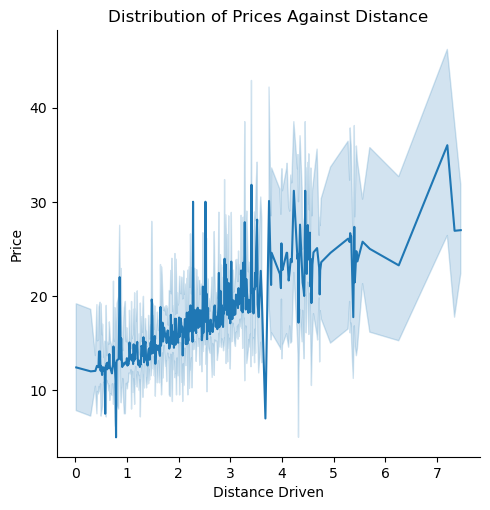

In [93]:
sns.relplot(data=df, x='distance', y='price', kind="line")
plt.title('Distribution of Prices Against Distance')
plt.xlabel('Distance Driven')
plt.ylabel('Price')

### Distribution of Price Surges Against Time of Day

# ML Implementation

## Overview

<strong>Executive Summary:</strong> I'd like to take the various inputs using various Regression models to try and predict the price of an Uber and Lyft. Using the same variables, I'd like to create seperate regression models for these two rideshare companies to analyze how their pricing model works. By analyzing their pricing models, we can determine if one company or the other unfairly prices customers.

In [23]:
# Extract features and target variables
x_feat = [col for col in df.columns if col not in ['price', 'datetime']]
y_feat = 'price'

x = df.loc[:, x_feat].values
y = df.loc[:, y_feat].values

In [24]:
# Split dataset into test and train values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)